Canny Edge Detection
Canny Steps:
1. Convolve image f with a Gaussian G of scale σ
2. Filter with Sobel kernel in both horizontal (gx) and vertical direction (gy)
3. Estimate the local edge gradient for each pixel
4. Find the location of the edge using zero crossing
5. Compute the magnitude of the edge at that location using Threshold edges with hysteresis to avoid “streaking problem” (breaking up of the edge contour caused by operator fluctuating above and below the threshold).

Thresholding with hysteresis:
1. Two thresholds are set, T1 and T2, T1<T2
2. Responses above T2 are actual edges
3. Responses below T1 are not edges
4. Responses between T1 and T2 are edges if  they are connected to any edges of the strong response.


## TODO: Implement Canny

In [ ]:
from scipy.signal import correlate2d
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

In [ ]:
def create_gaussian_filter(image,ksize, sigma):
  #create an array of size ksize with same distance from the kernel center to each element
  # to let the number rounded down to nearest integer and odd we divide by 2 using // and add 1
    z = np.arange(-ksize // 2 + 1.0, ksize // 2 + 1.0)
    x, y = np.meshgrid(z, z)
    kernel = np.exp((-1/2.0)*((x**2 - y**2) / ( sigma**2) ) )
    result=kernel / np.sum(kernel)
    result = correlate2d(image, G, mode='same')
    return result

In [ ]:

'''
 (Sobel operator)
'''
def sobel(image):
  sobel_filterX = np.asarray([[1, 0,- 1], [2, 0,-2], [1, 0,-1]], dtype=np.float32)  # should respond to horizontal gradients
  sobel_filterY = np.asarray([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype=np.float32) # should respond to Vertical gradients
  gx = correlate2d(image, sobel_filterX)
  gy = correlate2d(image, sobel_filterY)


  theta = np.arctan2(gy, gx) #direction
  magnitude = np.sqrt(gx ** 2 + gy ** 2)
  magnitude = (magnitude / np.max(magnitude)) * 255  # Normalization

  return magnitude,theta


# plt.figure();
# plt.imshow(sobel_image)
# done = save_image(resultsDir + os.sep + 'sobel_image.jpg', sobel_image)

In [ ]:
def non_maximum_suppression(gradient_magnitude, gradient_direction,image):
  suppressed = np.zeros_like(image)
  for i in range(1, image.shape[0]-1):
      for j in range(1, image.shape[1]-1):
          direction = gradient_direction[i, j] * 180 / math.pi # converted from radians to degrees
          if direction < 0:
               direction += 180
          direction = (direction + 22.5) % 180 #quantization
          if direction < 45:
              q = gradient_magnitude[i, j+1]
              r = gradient_magnitude[i, j-1]
          elif direction < 90:
              q = gradient_magnitude[i-1, j+1]
              r = gradient_magnitude[i+1, j-1]
          elif direction < 135:
              q = gradient_magnitude[i-1, j]
              r = gradient_magnitude[i+1, j]
          else:
              q = gradient_magnitude[i-1, j-1]
              r = gradient_magnitude[i+1, j+1]
          p = gradient_magnitude[i, j]
          if p >= q and p >= r:
              suppressed[i, j] = p

  return suppressed


In [ ]:
def canny_edge_detection(image, sigma=5, high_threshold_ratio=0.3, low_threshold_ratio=0.1):
    # Step 1: Gaussian smoothing
    G = create_gaussian_filter(image,5, sigma)
    # Step 2: Calculate gradient magnitude and orientation using Sobel operator
    gradient_magnitude, gradient_orientation = sobel(G)

    # Step 3: Non-maximum suppression
    suppressed = non_maximum_suppression(gradient_magnitude, gradient_orientation, image)
    plt.figure();
    plt.imshow(suppressed)
    # Double thresholding and edge tracking by hysteresis
    low = suppressed.max() * low_threshold_ratio
    high = suppressed.max() * high_threshold_ratio
    #detect strong and weak edges
# Thresholding with hysteresis:
# Two thresholds are set, T1 and T2, T1<T2
# Responses above T2 are actual edges
# Responses below T1 are not edges
# Responses between T1 and T2 are edges if they are connected to any edges of the strong response.

    edges = np.zeros_like(image)
    strong_i, strong_j = np.where(suppressed >= high) #actual edges
    weak_i, weak_j = np.where((suppressed >= low) & (suppressed < high))
    # Responses above T2 are actual edges
    edges[strong_i, strong_j] = 255 #marking as actual edges
    #keeping only strong edges by deleting the weak ones

    # Responses below T1 are not edges
    while len(weak_i) > 0:
      i, j = weak_i[0], weak_j[0]
      weak_i = np.delete(weak_i, 0)
      weak_j = np.delete(weak_j, 0)
      edges[i, j] = 255
      # Responses between T1 and T2 are edges if they are connected to any edges of the strong response.
      for x in range(max(0, i-1), min(image.shape[0], i+2)):
         for y in range(max(0, j-1), min(image.shape[1], j+2)):
             if edges[x, y] == 0 and suppressed[x, y] >= low and suppressed[x, y] < high:
                weak_i = np.append(weak_i, x)
                weak_j = np.append(weak_j, y)
                edges[x, y] = 255


    return edges

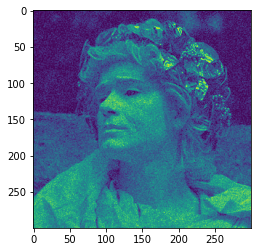

In [ ]:
# Test the kernel with a random image
image = cv2.imread('/content/300px-Kodim17_noisy.jpg',  cv2.IMREAD_GRAYSCALE)
plt.figure();
plt.imshow(image)

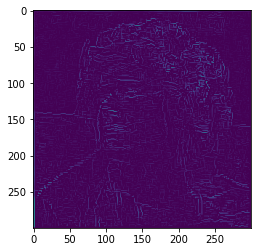

In [ ]:
edges=canny_edge_detection(image)

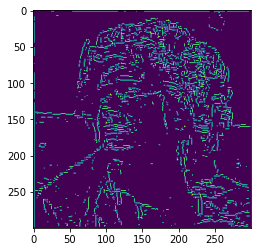

In [ ]:
plt.figure();
plt.imshow(edges)

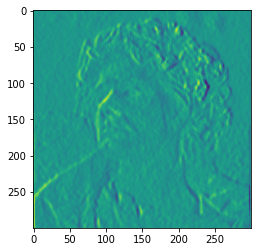

In [ ]:
plt.figure();
plt.imshow(gx)

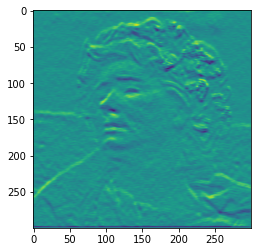

In [ ]:
plt.figure();
plt.imshow(gy)

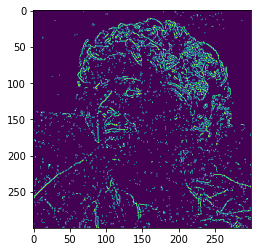

In [ ]:
img_canny = cv2.Canny(image, 250, 250)
plt.figure();
plt.imshow(img_canny)

Houph Transform task

Hough for Circles
It is the same concept as lines and a guide can be found here: Try it out https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghcircles/py_houghcircles.html

In [ ]:
def show_images(images, titles):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    assert len(images) == len(titles)
    images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
    fig = plt.figure()
    n_ims = len(images)
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

# How to use show_images([list of images], [list of titles]) They must have the same length
# show_images([img1, img2], ['This is image 1', 'This is image 2'])

In [ ]:
import cv2
from matplotlib import pyplot as plt
from skimage import io
import skimage
import numpy as np
%matplotlib inline

In [ ]:
img = cv2.imread('/content/hough circles.jfif')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(1, 112, 3)


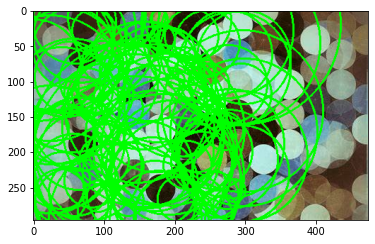

In [ ]:
circles = cv2.HoughCircles(image=edges,method=cv2.HOUGH_GRADIENT,dp=1,minDist=20,param1=50,param2=30,minRadius=0, maxRadius=0)

print(circles.shape)

img_copy = np.copy(img)


circles = np.round(circles[0, :]).astype("int")

# Draw the detected circles on the original image
for (x, y, r) in circles:
    cv2.circle(img, (x, y), r, (0, 255, 0), 2)

# Display the result
plt.figure();
plt.imshow(img)


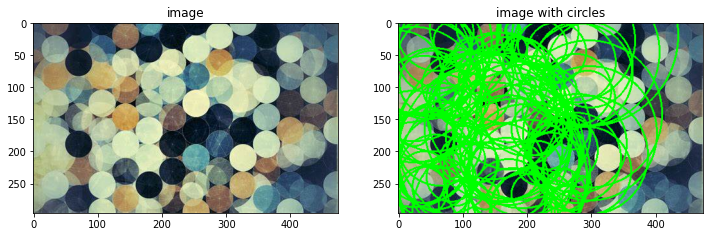

In [ ]:
show_images([img_copy, img], ['image', 'image with circles'])